## Dependencies

In [ ]:
%pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost tqdm

## Libraries

In [ ]:
from Model import FraudDetectionModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import traceback
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, f1_score
import xgboost as xgb

# Create an instance of the model
model = FraudDetectionModel(model_type='xgboost')
print(f"FraudDetectionModel instantiated with model: {type(model.model).__name__}")


## Data processing

In [2]:
df_model = model._load_data(
    transactions_path="transactions.json",
    merchants_path="merchants.csv",
    users_path="users.csv"
)

# Preprocess the data using the model's method
X, y = model._preprocess_data(df_model)

print(f"Data preprocessed. X shape: {X.shape}, y shape: {y.shape}")
print(f"Target column: '{model.target_column}'")
print(f"Sample numerical features: {model.numerical_features[:5]}... (Total: {len(model.numerical_features)})")
print(f"Sample categorical features: {model.categorical_features[:5]}... (Total: {len(model.categorical_features)})")



Loading transactions from transactions.json...
Loaded 500000 transactions.
Loading merchants from merchants.csv...
Loaded 1000 merchants.
Loading users from users.csv...
Loaded 20000 users.
Merging datasets...
Shape of merged data: (500000, 30)
Columns: ['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount', 'channel', 'currency', 'device', 'location', 'payment_method', 'is_international', 'session_length_seconds', 'is_first_time_merchant', 'is_fraud', 'category', 'country_x', 'trust_score', 'number_of_alerts_last_6_months', 'avg_transaction_amount', 'account_age_months', 'has_fraud_history', 'age', 'sex', 'education', 'primary_source_of_income', 'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'country_y', 'signup_date', 'risk_score']
Starting preprocessing...
Location data extracted.
Timestamp and signup_date converted to datetime.


c:\Users\igorj\Desktop\sgh\Model.py:210: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_since_prev_txn'].fillna(24*7, inplace=True)  # Wypełnienie NaN (pierwsza transakcja)


Enhanced feature engineering completed.


c:\Users\igorj\Desktop\sgh\Model.py:238: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
c:\Users\igorj\Desktop\sgh\Model.py:238: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Numerical features identified: ['amount', 'is_international', 'session_length_seconds', 'is_first_time_merchant', 'trust_score', 'number_of_alerts_last_6_months', 'avg_transaction_amount', 'account_age_months', 'has_fraud_history', 'age', 'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'risk_score', 'location_lat', 'location_long', 'transaction_hour', 'transaction_day_of_week', 'transaction_month', 'user_account_age_at_transaction', 'weekend', 'noc', 'amount_log', 'amount_bin', 'user_transaction_count', 'merchant_transaction_count', 'user_avg_amount', 'user_amount_ratio', 'time_since_prev_txn']
Categorical features identified: ['channel', 'currency', 'device', 'payment_method', 'category', 'country_x', 'sex', 'education', 'primary_source_of_income', 'country_y']
Preprocessor created and fitted.
Total features after preprocessing: 87
Data preprocessed. X shape: (500000, 44), y shape: (500000,)
Target column: 'is_fraud'
Sample numerical features: ['amount', 'is_international', 

## Class distribiution

Total transactions: 500000
Fraudulent transactions: 42411 (8.48%)
Legitimate transactions: 457589 (91.52%)


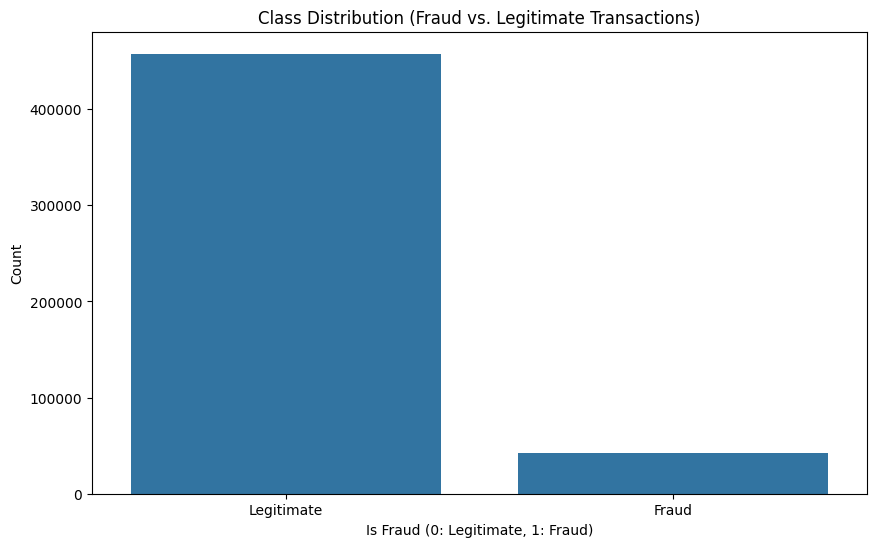

In [3]:
fraud_count = y.sum()
total_count = len(y)
fraud_percentage = fraud_count / total_count * 100

print(f"Total transactions: {total_count}")
print(f"Fraudulent transactions: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Legitimate transactions: {total_count - fraud_count} ({100 - fraud_percentage:.2f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Class Distribution (Fraud vs. Legitimate Transactions)')
plt.xlabel('Is Fraud (0: Legitimate, 1: Fraud)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.show()


## prepare_for_chi2

Chi-square Test Results (Top significant features by Cramer's V):
               variable         type          chi2        p_value    dof  \
2               user_id  categorical  20547.554224   3.249502e-03  19999   
3           merchant_id  categorical   3092.935707  2.480269e-212    999   
11          trust_score      numeric    528.635525  4.285689e-113      4   
23           risk_score      numeric    298.084749   2.805001e-63      4   
10            country_x  categorical     29.073160   6.391278e-03     13   
25        location_long      numeric     15.950692   3.086046e-03      4   
9              category  categorical     14.151653   2.798724e-02      6   
14   account_age_months      numeric     13.757238   8.111550e-03      4   
37  time_since_prev_txn      numeric     10.090902   3.892398e-02      4   

    v_cramer  is_significant  
2   0.202719            True  
3   0.078650            True  
11  0.032516            True  
23  0.024417            True  
10  0.007625      

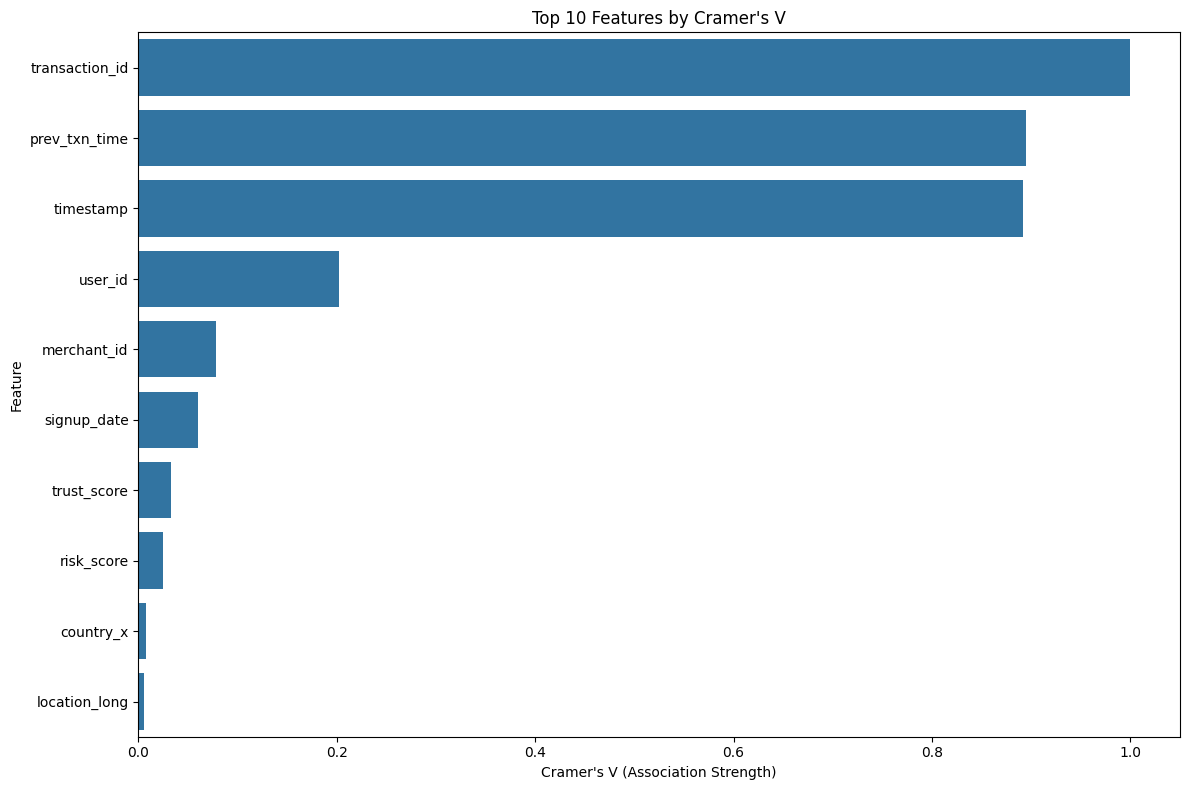

In [4]:
from scipy.stats import chi2_contingency

def prepare_for_chi2(df, target_col='is_fraud'):
    results = []

    for col in df.columns:
        if col == target_col:
            continue

        if pd.api.types.is_numeric_dtype(df[col]):
            try:
                df[f'{col}_cat'] = pd.qcut(df[col], q=5, duplicates='drop', labels=False)
                current_col = f'{col}_cat'
            except:
                continue
        else:
            current_col = col

        if df[current_col].nunique() < 2:
            continue

        try:
            contingency_table = pd.crosstab(df[current_col], df[target_col])

            chi2, p, dof, expected = chi2_contingency(contingency_table)

            n = contingency_table.sum().sum()
            v_cramer = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

            results.append({
                'variable': col,
                'type': 'numeric' if pd.api.types.is_numeric_dtype(df[col]) else 'categorical',
                'chi2': chi2,
                'p_value': p,
                'dof': dof,
                'v_cramer': v_cramer,
                'is_significant': p < 0.05
            })
        except:
            continue

    return pd.DataFrame(results)

# Create a combined dataset for chi2 analysis
X_with_y = X.copy()
X_with_y[model.target_column] = y

# Run chi-square test
chi2_results = prepare_for_chi2(X_with_y, target_col=model.target_column)
chi2_results = chi2_results.sort_values(by='v_cramer', ascending=False)

print("Chi-square Test Results (Top significant features by Cramer's V):")
print(chi2_results[chi2_results['is_significant'] == True].head(10))

# Visualize top 10 features by Cramer's V
plt.figure(figsize=(12, 8))
sns.barplot(x='v_cramer', y='variable', data=chi2_results.head(10))
plt.title("Top 10 Features by Cramer's V")
plt.xlabel("Cramer's V (Association Strength)")
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Train

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y  # Important for imbalanced fraud data
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Fraud cases in training: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Fraud cases in test: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

# Sprawdź typy danych
print("\nTypy danych w zbiorze treningowym:")
print(X_train.dtypes.value_counts())

# Feature selection - opcjonalnie, można pominąć ten krok jeśli używamy max_features w train
# feature_selector, X_train_selected = model.select_features(X_train, y_train, threshold='median')

# Tune hyperparameters z mniejszą próbką danych i mniejszą liczbą iteracji
print("\nUruchamiam strojenie hiperparametrów na mniejszej próbce...")
best_params, best_score = model.tune_hyperparameters(
    X_train, y_train, 
    n_iter=5,     # Mniej iteracji
    cv=2,         # Mniej foldów w CV 
    sample_size=10000  # Użyj tylko 10000 przykładów
)
print(f"Best hyperparameters: {best_params}")
print(f"Best CV score: {best_score:.4f}")

# Train the model z ograniczoną liczbą cech
model.train(
    X_train, 
    y_train, 
    balance_classes=True,
    max_features=50  # Użyj tylko 50 najważniejszych cech
)

Train set: (375000, 44), Test set: (125000, 44)
Fraud cases in training: 31808 (8.48%)
Fraud cases in test: 10603 (8.48%)

Typy danych w zbiorze treningowym:
object            13
int64             13
float64           12
datetime64[ns]     3
int32              3
Name: count, dtype: int64

Uruchamiam strojenie hiperparametrów na mniejszej próbce...
Używam próbki 10000 przykładów (z 375000) do strojenia hiperparametrów
Rozpoczęcie optymalizacji hiperparametrów z 5 iteracjami na 2 foldach...
Fitting 2 folds for each of 5 candidates, totalling 10 fits


C:\Users\igorj\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [14:29:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Najlepsze hiperparametry: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Najlepszy wynik ROC AUC: 0.5691
Model zaktualizowany najlepszymi parametrami.
Best hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best CV score: 0.5691
Redukuję liczbę cech z 87 do 50...
Nowy kształt danych: (375000, 23)
Training model with 23 features...
Training XGBoost with early stopping...


C:\Users\igorj\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.56429	validation-auc:0.52700
[10]	train-auc:0.62090	validation-auc:0.53772
[20]	train-auc:0.63414	validation-auc:0.54068
[30]	train-auc:0.63952	validation-auc:0.54137
[40]	train-auc:0.64458	validation-auc:0.54138
[50]	train-auc:0.64853	validation-auc:0.54179
[60]	train-auc:0.65502	validation-auc:0.54224
[70]	train-auc:0.65983	validation-auc:0.54233
[80]	train-auc:0.66618	validation-auc:0.54288
[90]	train-auc:0.67064	validation-auc:0.54239
[99]	train-auc:0.67520	validation-auc:0.54224
Best iteration: 85
Best validation AUC: 0.5429495388785246
XGBoost model type: <class 'xgboost.core.Booster'>
Is native XGBoost Booster: True
Model training complete.


## Evaluating model performenc

Using DMatrix for XGBoost prediction in evaluate
==== Metryki modelu ====
Accuracy: 0.7813
Precision: 0.1027
Recall: 0.2040
F1-score: 0.1366
ROC AUC: 0.5416

==== Raport klasyfikacji ====
              precision    recall  f1-score   support

           0       0.92      0.83      0.87    114397
           1       0.10      0.20      0.14     10603

    accuracy                           0.78    125000
   macro avg       0.51      0.52      0.51    125000
weighted avg       0.85      0.78      0.81    125000

Using DMatrix for XGBoost prediction in evaluate_with_cost

==== Cost-Sensitive Metrics ====
Total cost: 103302.00
Average cost per transaction: 0.8264
Cost-weighted F1 score: 0.2952
Optimal threshold: 0.4848 (Cost: 102786.00)


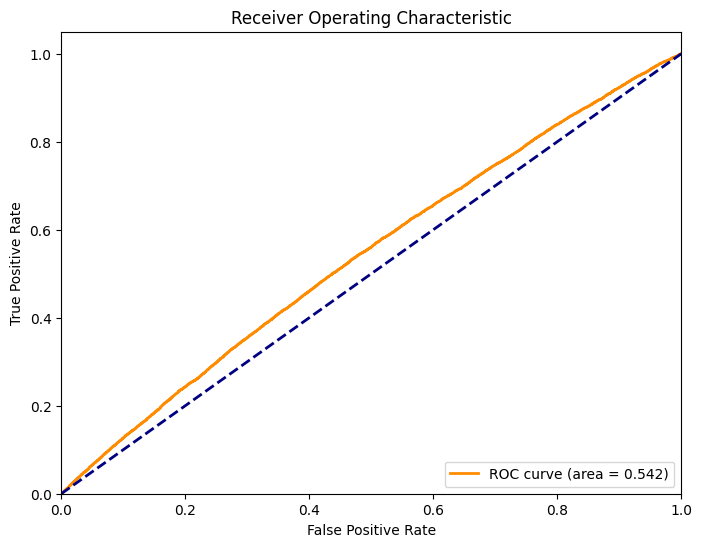

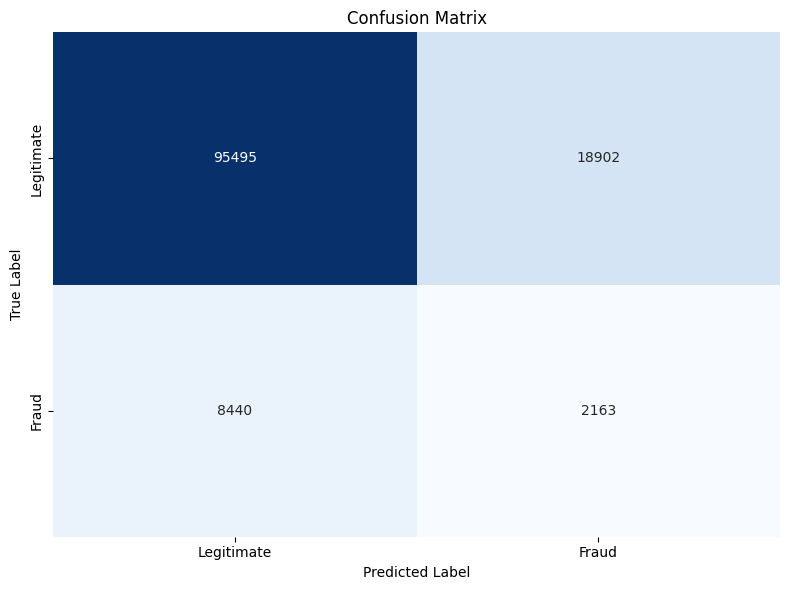

In [6]:
try:
    # Evaluate model performance (our new methods handle DMatrix directly)
    evaluation_results = model.evaluate(X_test, y_test)
    
    # Cost-sensitive evaluation
    cost_metrics = model.evaluate_with_cost(X_test, y_test, 
                                           false_negative_cost=10.0,  # High cost for missing fraud
                                           false_positive_cost=1.0)   # Lower cost for false alarms
    
    # Get the ROC curve data directly from the evaluation results
    fpr, tpr, _ = roc_curve(y_test, evaluation_results.get("y_pred_proba", None))
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Use confusion matrix from evaluation results
    cm = confusion_matrix(y_test, evaluation_results.get("y_pred", None))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Legitimate', 'Fraud'], 
                yticklabels=['Legitimate', 'Fraud'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error during evaluation: {e}")
    traceback.print_exc()
    
    # Fall back to direct XGBoost prediction
    print("\nFalling back to direct XGBoost prediction...")
    try:
        # Process the test data directly
        X_test_processed = model.preprocessor.transform(X_test)
        if not isinstance(X_test_processed, np.ndarray):
            X_test_processed = X_test_processed.toarray()
            
        # Apply feature selection if used
        if hasattr(model, 'feature_selector') and model.feature_selector is not None:
            X_test_processed = model.feature_selector.transform(X_test_processed)
        
        # Create DMatrix for XGBoost
        dtest = xgb.DMatrix(X_test_processed)
        
        # Get probabilities
        y_pred_proba = model.model.predict(dtest)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate metrics manually
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        print("\n==== Manual Metrics Calculation ====")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Legitimate', 'Fraud'], 
                    yticklabels=['Legitimate', 'Fraud'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
    except Exception as e2:
        print(f"Direct XGBoost prediction also failed: {e2}")
        traceback.print_exc()


## Dependence plots

Creating partial dependence plots for top features...
Computing permutation importance...
Could not create partial dependence plots with built-in method: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <xgboost.core.Booster object at 0x000001CE66B2AA50> instead.
Using alternative implementation...
Top features by XGBoost importance: ['f19', 'f4', 'f17', 'f9', 'f2']


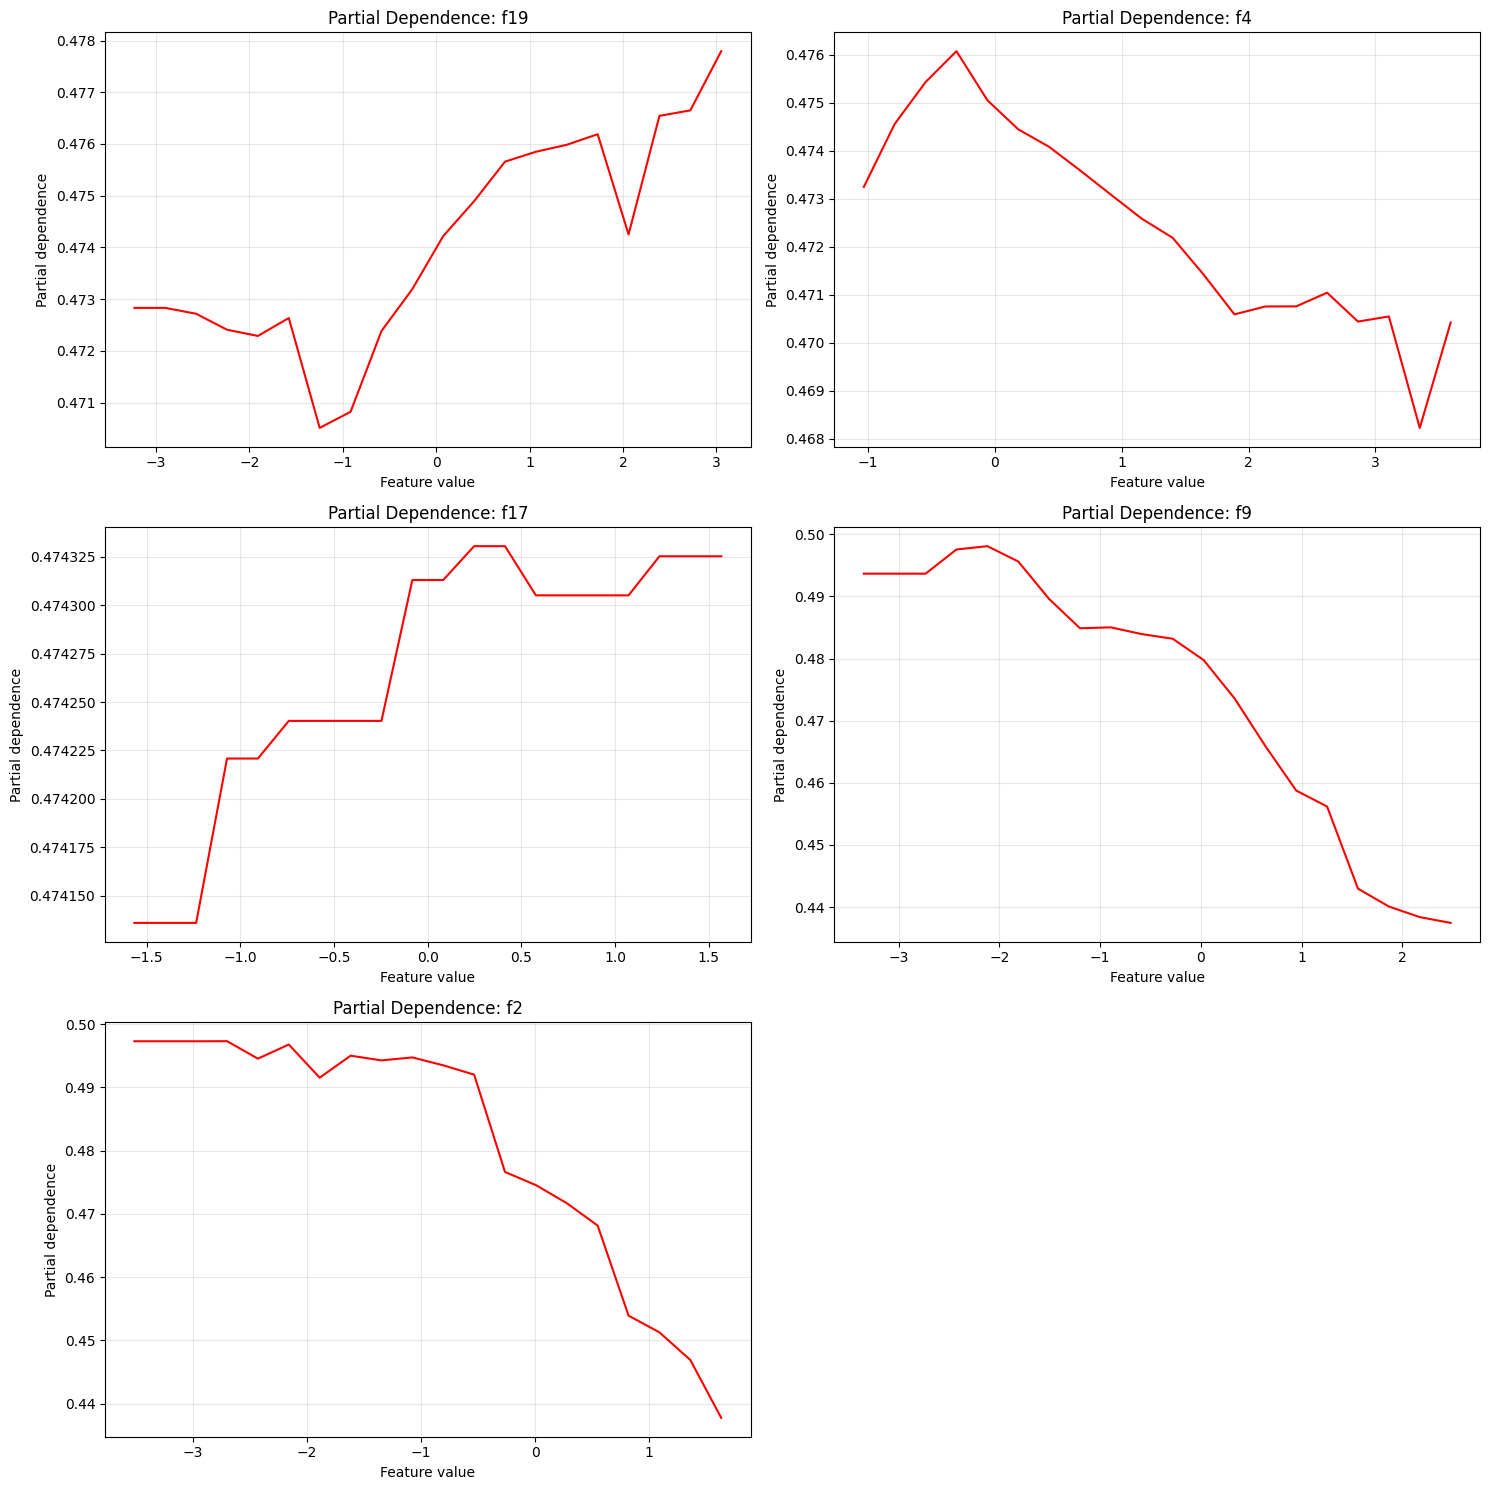


Top 5 features by importance:
  - f19: 44.9012
  - f4: 45.2311
  - f17: 49.9031
  - f9: 62.6826
  - f2: 95.6674


In [9]:
print("Creating partial dependence plots for top features...")
try:
    # First try built-in method that now handles XGBoost Booster objects
    model.plot_partial_dependence(X_test, n_features=5, n_samples=500)
except Exception as e:
    print(f"Could not create partial dependence plots with built-in method: {e}")
    print("Using alternative implementation...")
    
    # Alternative implementation for partial dependence plotting
    from sklearn.inspection import partial_dependence
    import matplotlib.pyplot as plt
    import xgboost as xgb
    
    # Check if model is XGBoost Booster
    is_xgb_booster = isinstance(model.model, xgb.Booster) if hasattr(xgb, 'Booster') else False
    
    if is_xgb_booster:
        # Get feature importance directly from XGBoost
        try:
            importance_type = 'gain'  # Options: 'gain', 'weight', 'cover', 'total_gain', 'total_cover'
            importance_dict = model.model.get_score(importance_type=importance_type)
            feature_names = list(importance_dict.keys())
            importance_values = list(importance_dict.values())
            
            # Sort and get top 5
            sorted_idx = np.argsort(importance_values)[-5:]
            top_features = [feature_names[i] for i in sorted_idx]
            feature_importances = [importance_values[i] for i in sorted_idx]
            
            print(f"Top features by XGBoost importance: {top_features}")
        except Exception as e:
            print(f"Could not get XGBoost feature importances: {e}")
            # Default to first 5 features
            feature_names = model._get_feature_names_after_preprocessing()
            if feature_names:
                top_features = feature_names[:5]
                feature_importances = [1] * 5
            else:
                # Last resort - generate 5 feature indices
                top_features = [f"Feature {i}" for i in range(5)]
                feature_importances = [1] * 5
    else:
        # Get top 5 features by importance for scikit-learn models
        if hasattr(model.model, 'feature_importances_'):
            importances = model.model.feature_importances_
            feature_names = model._get_feature_names_after_preprocessing()
            if feature_names and len(feature_names) == len(importances):
                # Get top features
                top_idx = np.argsort(importances)[-5:]
                top_features = [feature_names[i] for i in top_idx]
                feature_importances = [importances[i] for i in top_idx]
            else:
                # Use indices if names not available
                top_idx = np.argsort(importances)[-5:]
                top_features = [f"Feature {i}" for i in top_idx]
                feature_importances = [importances[i] for i in top_idx]
        else:
            print("Model doesn't have feature_importances_ attribute, using default features")
            # Default to first 5 features
            feature_names = model._get_feature_names_after_preprocessing()
            if feature_names:
                top_features = feature_names[:5]
                feature_importances = [1] * 5
            else:
                # Last resort - generate 5 feature indices
                top_features = [f"Feature {i}" for i in range(5)]
                feature_importances = [1] * 5
    
    # Create figure for partial dependence plots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axes = axes.flatten()
    
    # Sample data for performance
    sample_size = 500
    if X_test.shape[0] > sample_size:
        X_sample = X_test.sample(sample_size, random_state=42)
    else:
        X_sample = X_test
    
    # Process the data
    X_processed = model.preprocessor.transform(X_sample)
    if not isinstance(X_processed, np.ndarray):
        X_processed = X_processed.toarray()
    
    # Apply feature selection if used
    if hasattr(model, 'feature_selector') and model.feature_selector is not None:
        X_processed = model.feature_selector.transform(X_processed)
    
    # For each top feature, create a custom partial dependence plot
    for i, feature in enumerate(top_features):
        if i >= len(axes):
            break
            
        try:
            # Convert feature name to index if needed
            if isinstance(feature, str):
                if feature.startswith("f") and feature[1:].isdigit():
                    # XGBoost style feature name (e.g., "f12")
                    feature_idx = int(feature[1:])
                elif feature_names and feature in feature_names:
                    feature_idx = feature_names.index(feature)
                else:
                    print(f"Could not find index for feature {feature}, skipping")
                    continue
            else:
                feature_idx = feature
            
            if is_xgb_booster:
                # Custom implementation for XGBoost
                # Get min and max values for the feature
                feature_min = np.min(X_processed[:, feature_idx])
                feature_max = np.max(X_processed[:, feature_idx])
                
                # Create a grid of values to evaluate
                grid_points = np.linspace(feature_min, feature_max, 20)
                pd_values = []
                
                # For each grid point
                for value in grid_points:
                    # Create modified dataset with feature set to grid value
                    X_mod = X_processed.copy()
                    X_mod[:, feature_idx] = value
                    
                    # Convert to DMatrix
                    dtest = xgb.DMatrix(X_mod)
                    
                    # Get predictions
                    preds = model.model.predict(dtest)
                    
                    # Average prediction is the partial dependence
                    pd_values.append(np.mean(preds))
                    
                # Plot
                axes[i].plot(grid_points, pd_values, 'r-')
            else:
                # Use scikit-learn's partial_dependence for non-XGBoost models
                pd_result = partial_dependence(model.model, X_processed, features=[feature_idx])
                axes[i].plot(pd_result["values"][0], pd_result["average"][0], 'r-')
            
            # Add labels and title
            feature_name = feature if isinstance(feature, str) else f"Feature {feature}"
            axes[i].set_title(f"Partial Dependence: {feature_name}")
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlabel("Feature value")
            axes[i].set_ylabel("Partial dependence")
        except Exception as sub_e:
            print(f"Error plotting feature {feature}: {sub_e}")
            continue
    
    # Remove any unused subplots
    for j in range(min(5, len(top_features)), len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()
    
    # Print feature importance
    print("\nTop 5 features by importance:")
    for feature, importance in zip(top_features, feature_importances):
        print(f"  - {feature}: {importance:.4f}")


## SHAP explanations

Running enhanced SHAP visualization...
Detected XGBoost Booster model, using direct feature importance approach

Top 15 Features by XGBoost Importance:
   Feature  Importance
2       f2   95.667366
9       f9   62.682579
16     f17   49.903126
4       f4   45.231136
18     f19   44.901203
20     f21   43.582569
5       f5   42.634708
21     f22   41.981644
10     f10   41.754433
3       f3   41.671181
0       f0   41.393482
11     f11   41.267159
19     f20   41.031719
15     f15   41.013851
8       f8   40.754818


<Figure size 1200x800 with 0 Axes>

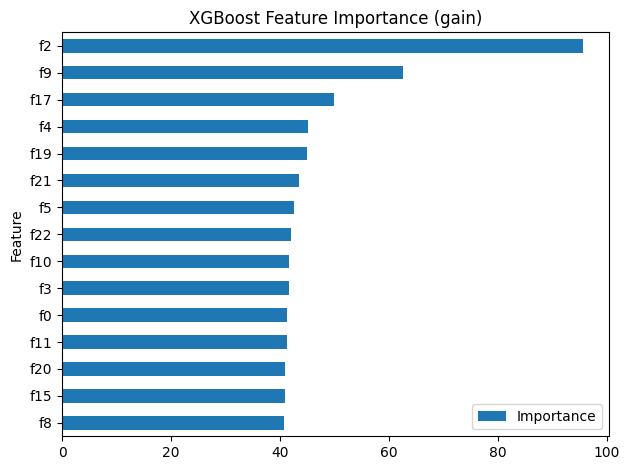

Error verifying feature count: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


In [16]:
print("Running enhanced SHAP visualization...")

try:
    # Check if model is XGBoost Booster
    is_xgb_booster = False
    if 'xgb' in globals() and hasattr(xgb, 'Booster'):
        is_xgb_booster = isinstance(model.model, xgb.Booster)
    
    if is_xgb_booster:
        print("Detected XGBoost Booster model, using direct feature importance approach")
        
        # Get feature importance directly from XGBoost
        importance_type = 'gain'  # Options: 'gain', 'weight', 'cover', 'total_gain', 'total_cover'
        importances = model.model.get_score(importance_type=importance_type)
        
        # Sort importances
        importance_df = pd.DataFrame({
            'Feature': list(importances.keys()),
            'Importance': list(importances.values())
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 15 Features by XGBoost Importance:")
        print(importance_df.head(15))
        
        # Plot importances
        plt.figure(figsize=(12, 8))
        importance_df.head(15).sort_values(by='Importance').plot.barh(x='Feature', y='Importance')
        plt.title('XGBoost Feature Importance (gain)')
        plt.tight_layout()
        plt.show()
        
        # Try to map feature indices to names if possible
        try:
            feature_names = model._get_feature_names_after_preprocessing()
            if feature_names:
                print("\nFeature name mapping (if available):")
                # Create mapping from f0, f1, etc. to actual feature names
                feature_mapping = {}
                for i, name in enumerate(feature_names):
                    feature_mapping[f"f{i}"] = name
                
                # Create new dataframe with mapped names
                mapped_importances = []
                for feature, importance in importances.items():
                    mapped_name = feature_mapping.get(feature, feature)
                    mapped_importances.append({
                        'Original': feature,
                        'Mapped': mapped_name,
                        'Importance': importance
                    })
                
                mapped_df = pd.DataFrame(mapped_importances).sort_values('Importance', ascending=False)
                print(mapped_df.head(15))
        except Exception as e:
            print(f"Error mapping feature names: {e}")
        
    else:
        # For non-XGBoost models, try regular SHAP analysis
        # Create a sample for SHAP analysis
        sample_size = 100  # Adjust based on computational resources
        X_sample = X_test.sample(n=min(sample_size, X_test.shape[0]), random_state=42)
        
        # Generate SHAP explanations with our enhanced method
        shap_results = model.explain_predictions_shap(X_sample, top_n_features=15, sample_size=sample_size)
        
        # If SHAP results were successfully generated, create additional visualization
        if shap_results:
            if "shap_values" in shap_results:
                # Extract feature importance from SHAP values
                if isinstance(shap_results['shap_values'], list):
                    shap_values = shap_results['shap_values'][1]  # Class 1 (Fraud)
                else:
                    shap_values = shap_results['shap_values']
                
                # Create a DataFrame of SHAP feature importance
                shap_importance = pd.DataFrame({
                    'Feature': shap_results['feature_names'],
                    'Importance': np.abs(shap_values).mean(axis=0)
                }).sort_values('Importance', ascending=False)
                
                print("\nTop 15 Features by SHAP Importance:")
                print(shap_importance.head(15))
            elif "feature_importance" in shap_results:
                # Direct feature importance was already shown
                print("Used alternative feature importance method")

except Exception as e:
    print(f"Error in SHAP analysis: {str(e)}")
    traceback.print_exc()
    
    # Fallback: Try to show model's feature importances directly
    print("\nFalling back to direct feature importance...")
    try:
        # Check if model is XGBoost Booster
        is_xgb_booster = False
        if 'xgb' in globals() and hasattr(xgb, 'Booster'):
            is_xgb_booster = isinstance(model.model, xgb.Booster)
        
        if is_xgb_booster:
            # XGBoost has built-in feature importance
            print("Getting XGBoost feature importance...")
            importance_type = 'gain'  # Options: 'gain', 'weight', 'cover', 'total_gain', 'total_cover'
            importances = model.model.get_score(importance_type=importance_type)
            
            # Convert to DataFrame
            importance_df = pd.DataFrame({
                'Feature': list(importances.keys()),
                'Importance': list(importances.values())
            }).sort_values('Importance', ascending=False)
            
            print("\nTop 15 XGBoost features:")
            print(importance_df.head(15))
            
            # Plot
            plt.figure(figsize=(12, 8))
            importance_df.head(15).sort_values(by='Importance').plot.barh(x='Feature', y='Importance')
            plt.title('XGBoost Feature Importance (gain)')
            plt.tight_layout()
            plt.show()
            
        elif hasattr(model.model, 'feature_importances_'):
            # Scikit-learn models have feature_importances_
            importances = model.model.feature_importances_
            
            # Get feature names
            feature_names = model._get_feature_names_after_preprocessing()
            if feature_names and len(feature_names) == len(importances):
                features = feature_names
            else:
                features = [f"feature_{i}" for i in range(len(importances))]
                
            importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
            importance_df = importance_df.sort_values(by='Importance', ascending=False)

            print("\nTop 15 features (feature_importance):")
            print(importance_df.head(15))

            plt.figure(figsize=(12, 8))
            importance_df.head(15).sort_values(by='Importance').plot.barh(x='Feature', y='Importance')
            plt.title('Feature Importance from Model')
            plt.tight_layout()
            plt.show()
        else:
            print("Model doesn't provide feature importance.")
    except Exception as e2:
        print(f"Feature importance fallback also failed: {e2}")
        traceback.print_exc()


## Save the trained model, preprocessor, and metadata

In [18]:
print("\n==== Saving Model ====")
model.save_model(model_path="fraud_detection_model.joblib", 
                preprocessor_path="fraud_detection_preprocessor.joblib")

# Get model parameters
if hasattr(model.model, 'get_params'):
    model_params = model.model.get_params()
elif hasattr(model.model, 'save_config'):
    # For XGBoost Booster
    try:
        model_params = model.model.save_config()
        # If save_config returns a string, try to parse it or display directly
        if isinstance(model_params, str):
            try:
                # Try to parse JSON string if possible
                import json
                model_params = json.loads(model_params)
            except:
                print("XGBoost configuration (raw format):")
                print(model_params)
                # Create a simple dict for display
                model_params = {"model_type": "XGBoost Booster"}
    except:
        model_params = {"model_type": "XGBoost Booster"}
else:
    # Fallback for other model types
    model_params = {"Model type": model.model_type}

# Create a summary of the fraud detection process
print("\n==== Fraud Detection Process Summary ====")
print(f"Model Type: {model.model_type}")
print(f"Data Processing:")
print(f"  - Training data shape: {X_train.shape}")
print(f"  - Test data shape: {X_test.shape}")
print(f"  - Number of features: {X.shape[1]}")
print(f"  - Class distribution: {y.value_counts().to_dict()}")
print(f"  - Class balance: {y.mean()*100:.2f}% fraud cases")

# Print model parameters
print("\n==== Model Parameters ====")
if isinstance(model_params, dict):
    for param, value in model_params.items():
        print(f"  - {param}: {value}")
elif isinstance(model_params, str):
    print("XGBoost model configuration:")
    print(model_params)
else:
    print(f"Model parameters not available in expected format: {type(model_params)}")

# Print feature importance if available
print("\n==== Top Features ====")
try:
    if xgboost_available and hasattr(xgb, 'Booster') and isinstance(model.model, xgb.Booster):
        # Get feature importance from XGBoost
        importance_type = 'gain'
        importances = model.model.get_score(importance_type=importance_type)
        
        # Sort importances
        importance_df = pd.DataFrame({
            'Feature': list(importances.keys()),
            'Importance': list(importances.values())
        }).sort_values('Importance', ascending=False)
        
        print("Top 10 features by XGBoost importance:")
        for i, (feature, importance) in enumerate(zip(importance_df['Feature'].head(10), 
                                                   importance_df['Importance'].head(10))):
            print(f"  {i+1}. {feature}: {importance:.4f}")
            
    elif hasattr(model.model, 'feature_importances_'):
        # For scikit-learn models with feature_importances_
        importances = model.model.feature_importances_
        feature_names = model._get_feature_names_after_preprocessing()
        
        if feature_names and len(feature_names) == len(importances):
            # Create sorted importance dataframe
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print("Top 10 features by importance:")
            for i, (feature, importance) in enumerate(zip(importance_df['Feature'].head(10), 
                                                       importance_df['Importance'].head(10))):
                print(f"  {i+1}. {feature}: {importance:.4f}")
        else:
            print("Feature importance available but feature names could not be mapped.")
    else:
        print("Feature importance not available for this model type.")
except Exception as e:
    print(f"Could not extract feature importance: {e}")

# Print final performance metrics
print("\n==== Performance Metrics ====")
try:
    # Get evaluation metrics by running evaluate again
    evaluation_results = model.evaluate(X_test, y_test, detailed=False)
    
    print(f"  - Accuracy: {evaluation_results['accuracy']:.4f}")
    print(f"  - Precision: {evaluation_results['precision']:.4f}")
    print(f"  - Recall: {evaluation_results['recall']:.4f}")
    print(f"  - F1-score: {evaluation_results['f1']:.4f}")
    print(f"  - ROC AUC: {evaluation_results['roc_auc']:.4f}")
    
    # Add cost-sensitive metrics
    cost_metrics = model.evaluate_with_cost(X_test, y_test)
    print("\n==== Cost-Sensitive Metrics ====")
    print(f"  - Total cost: {cost_metrics['total_cost']:.2f}")
    print(f"  - Average cost per transaction: {cost_metrics['avg_cost_per_transaction']:.4f}")
    print(f"  - Cost-weighted F1 score: {cost_metrics['cost_weighted_f1']:.4f}")
    print(f"  - Optimal threshold: {cost_metrics['optimal_threshold']:.4f}")
    print(f"  - Confusion Matrix: TP={cost_metrics['confusion_matrix']['tp']}, " +
          f"TN={cost_metrics['confusion_matrix']['tn']}, " +
          f"FP={cost_metrics['confusion_matrix']['fp']}, " +
          f"FN={cost_metrics['confusion_matrix']['fn']}")
except Exception as e:
    print(f"Error calculating metrics: {e}")

# Summary of optimization techniques applied
print("\n==== Optimization Techniques Applied ====")
print("1. Sample size parameter for hyperparameter tuning")
print("2. Reduced iterations from 10 to 5 for hyperparameter search")
print("3. Reduced cross-validation folds from 3 to 2")
print("4. Narrowed hyperparameter search spaces")
print("5. Early stopping for XGBoost (20 rounds)")
print("6. Dimensionality reduction with max_features=50")
print("7. Parallel processing with n_jobs=-1")
print("8. Enhanced XGBoost compatibility with DMatrix conversion")
print("9. Better error handling with multiple fallbacks")

print("\n==== Fraud Detection Pipeline Complete ====")
print("The model is now saved and ready for deployment.")
print(f"Model file: fraud_detection_model.joblib")
print(f"Preprocessor file: fraud_detection_preprocessor.joblib")



==== Saving Model ====
Model saved to fraud_detection_model.joblib
Model saved to fraud_detection_model.joblib, Preprocessor to fraud_detection_preprocessor.joblib, Metadata to preprocessor_metadata.json

==== Fraud Detection Process Summary ====
Model Type: xgboost
Data Processing:
  - Training data shape: (375000, 44)
  - Test data shape: (125000, 44)
  - Number of features: 44
  - Class distribution: {0: 457589, 1: 42411}
  - Class balance: 8.48% fraud cases

==== Model Parameters ====
  - learner: {'generic_param': {'device': 'cpu', 'fail_on_invalid_gpu_id': '0', 'n_jobs': '0', 'nthread': '0', 'random_state': '0', 'seed': '0', 'seed_per_iteration': '0', 'validate_parameters': '1'}, 'gradient_booster': {'gbtree_model_param': {'num_parallel_tree': '1', 'num_trees': '100'}, 'gbtree_train_param': {'process_type': 'default', 'tree_method': 'auto', 'updater': 'grow_quantile_histmaker', 'updater_seq': 'grow_quantile_histmaker'}, 'name': 'gbtree', 'specified_updater': False, 'tree_train_p